In [1]:
import torch
from torch.autograd import Variable
import shap
import numpy
import pandas
import argparse
import os 
from typing import Any, Dict, List
import pandas as pd
from torch.nn import MSELoss, L1Loss
import numpy as np
import json 
import random
from tqdm import tqdm
from pathlib import Path
from scipy.stats import binned_statistic
import matplotlib.pylab as plt


import torch

import torch_frame
from torch.nn import Linear, Module
from torch_frame.data import Dataset
from torch_frame.data import DataLoader
from torch_frame import TensorFrame, stype
from torch_frame.nn.models.ft_transformer import FTTransformer
from torch.nn import Linear, Module, ModuleList
from typing import Any, Dict, List
from torch import Tensor
import torch 

import torch_frame
from torch_frame import TensorFrame, stype
from torch_frame.data.stats import StatType
from torch_frame.nn.conv import TabTransformerConv, FTTransformerConvs
from torch_frame.nn.encoder import (
    EmbeddingEncoder,
    LinearEncoder,
    LinearEmbeddingEncoder,
    StypeWiseFeatureEncoder,
    MultiCategoricalEmbeddingEncoder,
    TimestampEncoder,
)


import sys
sys.path.append('../modeling/')

from model import TabTransformer, stype_encoder_dict_2, stype_encoder_dict_3

In [2]:
target = "price"
dense_features = ["LON", 
                "LAT", 
                "building_sqft", 
                "Lot Size", 
                "Year Built", 
                "Garage Number", 
                "Bedrooms", 
                "Baths", 
                "Maintenance Fee", 
                "Tax Rate", 
                "Recent Market Value", 
                "Recent Tax Value"]
cate = ["status", "Property Type", "County", "Private Pool", "Area Pool"]
time_col = ["date"]
cate_multi = ["Foundation_multiclass", "Garage Types_multiclass", 
            "Roof Type_multiclass", "Pool_feature_multiclass", "floor_type_multiclass", 
            "finance_option_multiclass", "Exterior Type_multiclass", "Style_multiclass"]

add_numerial_features = ["elementary_school_star", "middle_school_star", "high_school_star"]
add_cate_multi = ["school_org"] # ["school_names", "school_grades", "school_org"]
text_embedding_col = ["general_desc_roberta_mean_features"]
img_embedding_col = ["img_emb"]
raw_df = pd.read_pickle("../data/property_structured_12162024.pkl").reset_index(drop=True)

In [3]:
raw_df["date"] = raw_df["date"].apply(lambda x: x.replace("_", "-"))
# raw_df["date"] = pd.to_datetime(raw_df["date"])
dense_features = dense_features + add_numerial_features
cate_multi = cate_multi + add_cate_multi

col_to_stype = {}
col_to_stype = {d: stype.numerical for d in dense_features}
col_to_stype.update({d: stype.timestamp for d in time_col})
col_to_stype.update({target: stype.numerical})
col_to_stype.update({d: stype.categorical for d in cate})
col_to_stype.update({d: stype.multicategorical for d in cate_multi})

text_emb_df = pd.read_pickle("../data/property_structured_12162024_general_desc_features.pkl")
raw_df = raw_df.join(text_emb_df.set_index("address_key")[text_embedding_col], 
             on="address_key", 
             how="left")
img_emb_df = pd.read_pickle("../data/property_structured_12162024_image_dinov2s_cls_mean.pkl")
raw_df = raw_df.join(img_emb_df.set_index("address_key")[["img_emb"]], 
             on="address_key", 
             how="left")
raw_df = raw_df[dense_features + cate + cate_multi + time_col + text_embedding_col + img_embedding_col + [target]]
col_to_stype.update({d: stype.embedding for d in img_embedding_col + text_embedding_col})
stype_encoder_dict = stype_encoder_dict_3

for col in cate_multi:
    raw_df[col] = raw_df[col].apply(lambda d: d if isinstance(d, list) else [])

dataset = Dataset(
    raw_df, 
    col_to_stype=col_to_stype,
    target_col="price"
)
dataset.materialize(path="../data/property_structured_12162024_tabformer_t32c.pt")
torch.manual_seed(10)
dataset.shuffle()
train_dataset, val_dataset = dataset[:0.8], dataset[0.80:]

In [4]:
train_loader = DataLoader(train_dataset.tensor_frame, 
                          batch_size=2048,
                          shuffle=True)
val_loader = DataLoader(val_dataset.tensor_frame, batch_size=16)
train_loader.tensor_frame

TensorFrame(
  num_cols=32,
  num_rows=169568,
  numerical (15): ['Baths', 'Bedrooms', 'Garage Number', 'LAT', 'LON', 'Lot Size', 'Maintenance Fee', 'Recent Market Value', 'Recent Tax Value', 'Tax Rate', 'Year Built', 'building_sqft', 'elementary_school_star', 'high_school_star', 'middle_school_star'],
  timestamp (1): ['date'],
  categorical (5): ['Area Pool', 'County', 'Private Pool', 'Property Type', 'status'],
  multicategorical (9): ['Exterior Type_multiclass', 'Foundation_multiclass', 'Garage Types_multiclass', 'Pool_feature_multiclass', 'Roof Type_multiclass', 'Style_multiclass', 'finance_option_multiclass', 'floor_type_multiclass', 'school_org'],
  embedding (2): ['general_desc_roberta_mean_features', 'img_emb'],
  has_target=True,
  device='cpu',
)

In [5]:
train_iter = iter(train_loader)
val_iter = iter(val_loader)
tf = next(train_iter)
all_col_names = []
for stype in tf.stypes:
    col_names = train_loader.tensor_frame.col_names_dict[stype]
    all_col_names.extend(col_names)

In [6]:
# 
tf = next(train_iter)
tf_val = next(val_iter)

In [7]:
# class TabTransformer(Module):
#     def __init__(
#         self,
#         channels: int,
#         num_layers: int,
#         num_heads: int,
#         col_stats: Dict[str, Dict[StatType, Any]],
#         col_names_dict: Dict[torch_frame.stype, List[str]],
#         stype_encoder_dict, 
#         out_channels: int = 1,
#     ):
#         super().__init__()
#         self.encoder = StypeWiseFeatureEncoder(
#             out_channels=channels,
#             col_stats=col_stats,
#             col_names_dict=col_names_dict,
#             stype_encoder_dict=stype_encoder_dict,
#         )
#         self.tab_transformer_convs = ModuleList([
#             TabTransformerConv(
#                 channels=channels,
#                 num_heads=num_heads,
#             ) for _ in range(num_layers)
#         ])
#         self.decoder = Linear(channels, out_channels)

#     def forward(self, x) -> Tensor:
#         for tab_transformer_conv in self.tab_transformer_convs:
#             x = tab_transformer_conv(x)
#         out = self.decoder(x.mean(dim=1))
#         return out
    
#     def encode(self, tf: TensorFrame) -> Tensor:
#         x, all_col_names = self.encoder(tf)
#         return x, all_col_names

model = TabTransformer(
        channels=32,
        num_layers=8,
        num_heads=8,
        col_stats=train_dataset.col_stats,
        col_names_dict=train_dataset.tensor_frame.col_names_dict,
        stype_encoder_dict=stype_encoder_dict, 
    )

In [8]:
model.state_dict()["encoder.encoder_dict.numerical.weight"][0, :]

tensor([-0.0086, -0.0094, -0.0008, -0.0128, -0.0041, -0.0096,  0.0093,  0.0056,
        -0.0071, -0.0064, -0.0032, -0.0096, -0.0088,  0.0217,  0.0065, -0.0056,
         0.0027,  0.0106,  0.0100, -0.0031, -0.0090, -0.0044,  0.0041, -0.0018,
         0.0239,  0.0083, -0.0177,  0.0051,  0.0015, -0.0069, -0.0009,  0.0102])

In [29]:
model_path = "../model_checkpoints/tabformer_t30/final_model.pth"
loaded = torch.load(model_path)
# model.load_state_dict(loaded["model_weight"])
# _ = model.eval()
# train_pred = model(tf)

In [27]:
torch.mean(torch.abs((tf.y - train_pred)))

tensor(60693.6602, grad_fn=<MeanBackward0>)

In [20]:
train_pred

tensor([683668.6250, 658774.2500, 327371.7500,  ..., 267615.8125,
        317145.9375, 462647.2500], grad_fn=<SqueezeBackward0>)

In [33]:
model.state_dict()["encoder.encoder_dict.numerical.weight"][0, :]

tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan])

In [40]:
stype = tf.stypes[0]
["%0.2f"%(f) for f in model.encoder.encoder_dict[stype.value].mean]

['2.58',
 '3.53',
 '2.22',
 '-96.42',
 '30.84',
 '25683.35',
 '86.73',
 '407162.81',
 '369465.94',
 '31.52',
 '2002.74',
 '2247.74',
 '3.95',
 '3.79',
 '3.47']

In [39]:
["%0.2f"%(f) for f in model.encoder.encoder_dict[stype.value].std]

['0.88',
 '0.84',
 '36.54',
 '2.26',
 '1.48',
 '4184878.75',
 '166.84',
 '397780.06',
 '362370.81',
 '12332.50',
 '99.15',
 '967.13',
 '1.21',
 '1.15',
 '1.38']

In [15]:
torch.set_grad_enabled(True)
e = shap.DeepExplainer(model, x)
shap_values = e.shap_values(x_val, check_additivity=False)
shap_values = shap_values.reshape(16, 32, 32)

/opt/conda/lib/python3.10/site-packages/shap/explainers/_deep/deep_pytorch.py:243: UserWarning: unrecognized nn.Module: GEGLU
  warnings.warn(f'unrecognized nn.Module: {module_type}')
/opt/conda/lib/python3.10/site-packages/shap/explainers/_deep/deep_pytorch.py:243: UserWarning: unrecognized nn.Module: LayerNorm
  warnings.warn(f'unrecognized nn.Module: {module_type}')


In [16]:
mean_abs_feature_importance = np.mean(np.mean(np.abs(shap_values), axis=2), axis=0)

<BarContainer object of 32 artists>

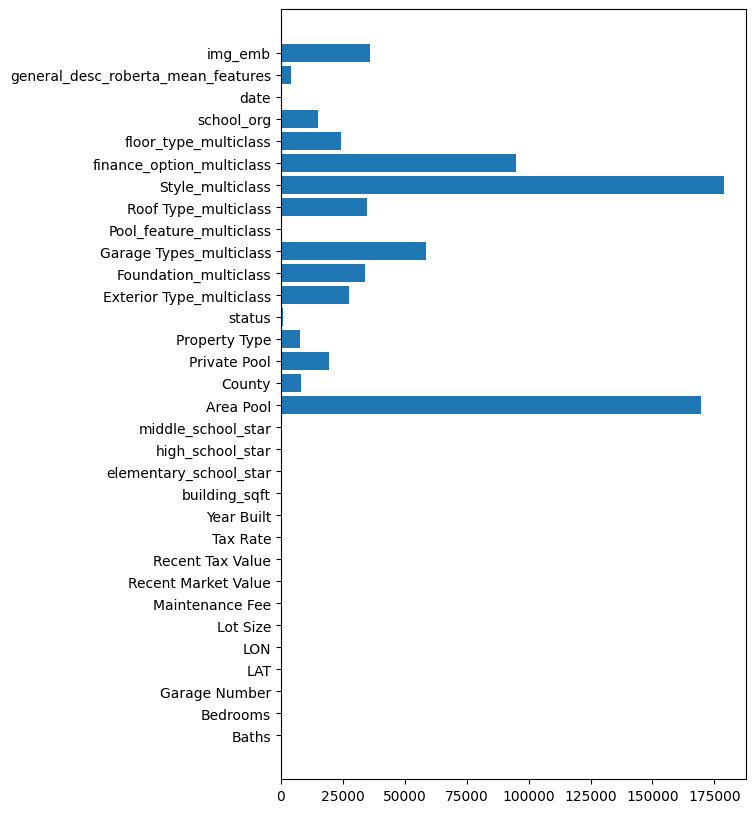

In [17]:
plt.figure(figsize=(6, 10))
plt.barh(col_names, mean_abs_feature_importance)